In [1]:
import numpy as np
import pandas as pd
import dash
from dash import dcc
import dash_daq as daq
from dash import html
from dash import dash_table
from dash.dependencies import Input, Output
import psycopg2
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import os
import plotly.figure_factory as ff
import plotly.express as px
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')
import dash_bootstrap_components as dbc

In [2]:
engine = create_engine('postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}'.format(
    user = 'postgres',
    password = POSTGRES_PASSWORD,
    host = 'postgres',
    port = 5432,
    db = 'neurodash'
))

In [3]:
external_stylesheets = [dbc.themes.BOOTSTRAP]

In [4]:
mymarkdown = '''
NeuroDash is a dashboard to view the current neuroscience literature. The data for this dashobard come from [NeuroMorpho](https://neuromorpho.org/), [NeuroElectro](https://neuroelectro.org/), and [ModelDB](https://modeldb.science/). NeuroMorpho provides morphological data for neurons researchers find. NeuroElectro provides information about the electrophysiological properties of neurons found in the literature. Lastly, ModelDB provides information about computation neual models that researchers have created. These resources combine to illustrate research trends and findings in Neuroscience. They can serve as a jumping off point for someone looking to do their own research.
'''

In [5]:
myquery = '''
SELECT primary_brain_region, 
    COUNT(*) AS n_neurons
FROM neuron
WHERE primary_brain_region IS NOT NULL
GROUP BY primary_brain_region
ORDER BY n_neurons
    DESC
'''
data = pd.read_sql_query(myquery, con = engine)
primary_brain_regions = [x for x in data['primary_brain_region']]

In [6]:
measurements = ['soma_surface', 'n_stems', 'n_bifs', 'n_branch', 'width', 'height', 'depth', 'diameter', 'length']

In [7]:
myquery = '''
SELECT brainregion
FROM electro
WHERE brainregion IS NOT NULL
GROUP BY brainregion
'''
electro_regions = pd.read_sql_query(myquery, con = engine)

### Exploring how the neuron, electro, models data can combine on 
* brain_region
* pmid
* doi
* celltype ?

In [8]:
# there are some combos for the brain reigon in neuron to electro (cerebellum, hypothalamus, medulla, thalamus)
myquery = '''
SELECT n.primary_brain_region,
    e.brainregion
FROM neuron n
INNER JOIN electro e
    ON n.primary_brain_region = e.brainregion
GROUP BY n.primary_brain_region, 
    e.brainregion
'''
n_e_region = pd.read_sql_query(myquery, con = engine)

In [9]:
n_e_shared_regions = n_e_region['primary_brain_region'].unique()

In [10]:
# n_e_region
myquery = '''
SELECT n.neuron_id,
    e.electro_id
FROM neuron n
INNER JOIN electro e
    ON n.primary_brain_region = e.brainregion
GROUP BY n.neuron_id,
    e.electro_id
'''
n_e_link_region = pd.read_sql_query(myquery, con = engine)

In [11]:
# 10724 neurons to electro based on region
len(n_e_link_region['neuron_id'].unique())

10724

In [12]:
# neuron to electo pmid mapping
myquery = '''
SELECT j.neuron_id,
    e.electro_id
FROM electro e
INNER JOIN (SELECT *
FROM neuron_pmid n
INNER JOIN electro_pub e
    ON n.reference_pmid = CAST(e.pmid AS VARCHAR)) j
    ON CAST(e.pmid AS VARCHAR) = CAST(j.pmid AS VARCHAR)
GROUP BY j.neuron_id,
    e.electro_id
'''
n_e_pmid = pd.read_sql_query(myquery, con = engine)

In [13]:
len(n_e_pmid['neuron_id'].unique())

939

In [14]:
myquery = '''
SELECT j.model_id, 
    mr.primary_brain_region
FROM (SELECT m.model_id, 
            mtr.model_region_id
        FROM models m
        INNER JOIN model_to_region mtr
            ON m.model_id = mtr.model_id) j
INNER JOIN model_regions mr
    ON j.model_region_id = mr.model_region_id
'''
model_regions = pd.read_sql_query(myquery, con = engine)

In [15]:
myquery = '''
SELECT n.neuron_id,
    n.primary_brain_region
FROM neuron n
'''
neuron = pd.read_sql_query(myquery, con = engine)

In [16]:
n_m_shared_regions = [x for x in neuron['primary_brain_region'].unique() if x in model_regions['primary_brain_region'].unique()]

In [17]:
three_shared_regions = [x for x in n_e_shared_regions if x in n_m_shared_regions]

In [ ]:
myquery = '''
SELECT n.neuron_id,
    k.model_id,
    n.primary_brain_region,
    k.primary_brain_region
FROM neuron n
INNER JOIN (SELECT j.model_id, 
            mr.primary_brain_region
        FROM (SELECT m.model_id, 
                    mtr.model_region_id
                FROM models m
                INNER JOIN model_to_region mtr
                    ON m.model_id = mtr.model_id) j
        INNER JOIN model_regions mr
            ON j.model_region_id = mr.model_region_id) k
    ON n.primary_brain_region = k.primary_brain_region
'''
pd.read_sql_query(myquery, con = engine)

In [18]:
three_shared_regions

['cerebellum', 'thalamus']

In [102]:
electro_properties = ['jxnpotential', 'rin', 'rmp', 'apthr', 'aphw', 'tau', 'cap', 'apwidth', 'apfreq', 'rheo', 'sagratio', 'maxfreq', 'appeak', 'apdelay']
electro_summaries = ['brainregion', 'species', 'strain', 'electrodetype', 'preptype']

In [104]:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
    [
        html.H1("NeuroDash"),
        html.H2("Data collected from NeuroMorpho, NeuroElectro, & ModelDB"),
        html.H3("DS 6600: Data Engineering 1, UVA Data Science"),
        html.Div([
            dcc.Markdown('''**Pick the sources you want to be able to see all data from**'''),
            dcc.Checklist(options=[
                               {'label': 'NeuroMorpho', 'value': 'NeuroMorpho'},
                               {'label': 'NeuroElectro', 'value': 'NeuroElectro'},
                               {'label': 'ModelDB', 'value': 'ModelDB'},
                           ],
                           value=['NeuroMorpho'], id = 'source_checklist'),
            dcc.Markdown('''**Pick a Primary Brain Region to Study**'''),
            html.Div(id = 'data_source'),
            dcc.Markdown(mymarkdown)
        ], style = {'width': '24%', 'float': 'left'}),
        html.Div([
            dcc.Tabs([
                dcc.Tab(label = 'NeuroMorpho', children = [
                    # stuff for NeuroMorpho Goes Here
                    dcc.Tabs([
                        dcc.Tab(label = 'Measurements', children = [
                            dcc.Markdown('''Select a Measure to Graph:'''),
                            dcc.Dropdown(id = 'measurement', options = measurements, value = 'soma_surface'),
                            daq.BooleanSwitch(id = 'log', label = 'Logarithmic Measurement', on = False),
                            dcc.Graph(id = 'NeuronMeasurementGraph'),
                            html.Div([dcc.Graph(id = 'NeuronRegionTable')])
                        ]),
                        dcc.Tab(label = 'Publications', children = [
                            # put stuff for NeuroMorpho publications
                            
                        ]),
                        dcc.Tab(label = 'Images', children = [
                            # put stuff for NeuroMorpho Images
                            dcc.Markdown('''Below is an example neuron and some basic information about it it:'''),
                            html.Div([dcc.Graph(id = 'NeuroMorphPicTable')]),
                            html.Div([html.Img(id = 'NeuroMorphPic', style={'height':'100%', 'width':'100%'})])      
                        ])
                    ])
                ]),
                dcc.Tab(label = 'NeuroElectro', children = [
                    # stuff for NeuroElectro goes Here
                    dcc.Tabs([
                        dcc.Tab(label = 'Brain Region Measurements', children = [
                            dcc.Markdown('''**Select from below the electrophysiological properties you want to explore:**'''),
                            dcc.Markdown('''*Disclaimer: If no graph appears, it is likely that there is no data for this brain region or variable. You can help find these values in the literature or through your own research!*'''),
                            dcc.Dropdown(id = 'ElectroDropDown', options = electro_properties, value = 'rmp'),
                            dcc.Graph(id = 'ElectroGraph')
                        ]),
                        dcc.Tab(label = 'Summary Data', children = [
                            dcc.Markdown('''Below is summary data on what observations can be found from NeuroMorpho:'''),
                            dcc.Dropdown(id = 'ElectroSummaryDropdown', options = electro_summaries, value = 'brainregion'),
                            dcc.Graph(id = 'ElectroSummaryGraph')
                        ])
                                
                    ])
                ]),
                dcc.Tab(label = 'ModelDB', children = [
                    # stuff for ModelDB goes here
                    
                ])
            ])
        ], style = {'width': '74%', 'float': 'right'})
    ]
)

@app.callback([Output(component_id = 'NeuronRegionTable', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value')])

def NeuronRegionTable(primary_brain_region):
    myquery = f'''
    SELECT ROUND(AVG(soma_surface)) AS soma_surface,
        ROUND(AVG(n_stems)) AS number_stems,
        ROUND(AVG(n_bifs)) AS number_biffurcations,
        ROUND(AVG(n_branch)) AS number_branches,
        ROUND(AVG(width)) AS width,
        ROUND(AVG(height)) AS height,
        ROUND(AVG(depth)) AS depth,
        ROUND(AVG(diameter)) AS diameter,
        ROUND(AVG(length)) AS length
    FROM neuron
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)
    data['primary_brain_region'] = pd.Series([primary_brain_region])

    data.rename(columns = {'primary_brain_region': 'Region',
                'soma_surface': 'Soma Surface',
                'number_stems': 'Num Stems',
                'number_biffurcations': 'Num Biffurcations',
                'number_branches': 'Num Branches',
                'width': 'Width',
                'height': 'Height',
                'depth': 'Depth',
                'diameter': 'Diameter',
                'length': 'Length'}, inplace = True)
    
    table = ff.create_table(data[['Region', 'Soma Surface', 'Num Stems', 'Num Biffurcations',
       'Num Branches', 'Width', 'Height', 'Depth', 'Diameter', 'Length']])
    return [table]

@app.callback([Output(component_id = 'data_source', component_property = 'children')],
             [Input(component_id = 'source_checklist', component_property = 'value')])
def SelectDataSources(s):
    if ('NeuroElectro' in s) & ('ModelDB' in s):
        options = three_shared_regions
    elif ('NeuroElectro' in s) & ('ModelDB' not in s):
        options = n_e_shared_regions
    elif ('NeuroElectro' not in s) & ('ModelDB' in s):
        options = n_m_regions
    else:
        options = primary_brain_regions
    return [dcc.Dropdown(options = options, value = 'thalamus', id = 'primary_brain_region')]

@app.callback([Output(component_id = 'NeuronMeasurementGraph', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value'),
             Input(component_id = 'measurement', component_property = 'value'),
             Input(component_id = 'log', component_property = 'on')])

def NeuronMeasurement(primary_brain_region, measurement, log):
    myquery = f'''
    SELECT {measurement}
    FROM neuron
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)
    title = 'Box plot for Neuron ' + measurement + ' in the ' + primary_brain_region
    if log:
        xaxis = 'Log Measurement of ' + measurement
    else:
        xaxis = measurement
    fig = px.box(x = data[measurement], log_x = log, title = title)
    fig.update_layout(xaxis_title = xaxis)

    return [fig]

@app.callback([Output(component_id = 'NeuroMorphPic', component_property = 'src'),
              Output(component_id = 'NeuroMorphPicTable', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value')])

def NeuroMorphoImage(primary_brain_region):
    primary_brain_region = 'neocortex'
    myquery = f'''
    SELECT n.neuron_id,
        n.neuron_name AS Name, 
        n.primary_brain_region AS Region, 
        n.png_url,
        nd.reference_doi AS DOI,
        n.species,
        n.strain
    FROM neuron n
    INNER JOIN neuron_doi nd
        ON n.neuron_id = nd.neuron_id
    WHERE primary_brain_region = '{primary_brain_region}' AND png_url IS NOT NULL
    '''
    data = pd.read_sql_query(myquery, con = engine)
    data.rename(columns = {'name': 'Name',
                          'region': 'Region',
                          'doi': 'DOI',
                          'species': 'Species',
                          'strain': 'Strain'}, inplace = True)
    
    sampled_row = data.sample()
    
    sampled_row['DOI'] = 'https://doi.org/' + sampled_row['DOI'].iloc[0]
    doi = sampled_row['DOI'].iloc[0]
    url = sampled_row['png_url'].iloc[0]
    fig = ff.create_table(sampled_row[['Name', 'Region', 'Species', 'Strain', 'DOI']])

    return [url, fig]

@app.callback([Output(component_id = 'ElectroGraph', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value'),
             Input(component_id = 'ElectroDropDown', component_property = 'value')])

def ElectroMeasurements(primary_brain_region, value):
    try:
        myquery = f'''
        SELECT {value}
        FROM electro
        WHERE brainregion = '{primary_brain_region}' AND {value} IS NOT NULL
        '''
        data = pd.read_sql_query(myquery, con = engine)
        num_observation = len(data)
        xaxis = value
        fig = px.box(x = data[value], title = value + ' for Neurons found in the ' + primary_brain_region + ' (n = ' + str(num_observation) + ')')
        fig.update_layout(xaxis_title = xaxis,
                         title_x = 0.5)
        return [fig]
    except:
        return [None]

@app.callback([Output(component_id = 'ElectroSummaryGraph', component_property = 'figure')],
             [Input(component_id = 'ElectroSummaryDropdown', component_property = 'value')])

def ElectroSummaryGraph(value):
    myquery = f'''
    SELECT {value},
        COUNT({value}) AS num_observations
    FROM electro
    GROUP BY {value}
    HAVING {value} IS NOT NULL
    ORDER BY num_observations
    DESC
    '''
    data = pd.read_sql_query(myquery, con = engine)
    fig = px.bar(y = data[value], x = data['num_observations'], title = 'Number of Observations for ' + value + ' in NeuroElectro')
    fig.update_layout(xaxis_title = 'Number of Observations',
                     yaxis_title = value,
                     title_x = 0.5)
    return [fig]
    
# Execution
if __name__ == "__main__":
    app.run_server(mode='external', host = '0.0.0.0', port = 8050, debug = True)

In [ ]:
primary_brain_region = 'neocortex'
myquery = f'''
SELECT *
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)

In [64]:
test = ['NeuroMorpho', 'NeuroElectro', 'ModelDB']
if ('ModelDB' in test) & ('NeuroElectro' in test):
    print('yes')

yes


In [ ]:
neuron_columns = [x for x in data.columns]

In [ ]:
data.columns

In [ ]:
# gender, age_classification, species, png_url, primary_brain_region, dendrites, soma, axon, processes, neurites, soma_surface, n_stems, n_biffs, n_branch, width, height, depth, diameter, length
primary_brain_region = 'neocortex'
myquery = f'''
SELECT ROUND(AVG(soma_surface)) AS soma_surface,
    ROUND(AVG(n_stems)) AS number_stems,
    ROUND(AVG(n_bifs)) AS number_biffurcations,
    ROUND(AVG(n_branch)) AS number_branches,
    ROUND(AVG(width)) AS width,
    ROUND(AVG(height)) AS height,
    ROUND(AVG(depth)) AS depth,
    ROUND(AVG(diameter)) AS diameter,
    ROUND(AVG(length)) AS length
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)
data['primary_brain_region'] = pd.Series([primary_brain_region])

table = ff.create_table(data[['primary_brain_region', 'soma_surface', 'number_stems', 'number_biffurcations',
   'number_branches', 'width', 'height', 'depth', 'diameter', 'length']])

In [ ]:
primary_brain_region = 'neocortex'
measurement = 'height'
log = True
myquery = f'''
SELECT {measurement}
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)
title = 'Box plot for Neuron ' + measurement + ' in the ' + primary_brain_region
if log:
    xaxis = 'Log Measurement of ' + measurement
else:
    xaxis = measurement
fig = px.box(x = data[measurement], log_x = log, title = title)
fig.update_layout(xaxis_title = xaxis)

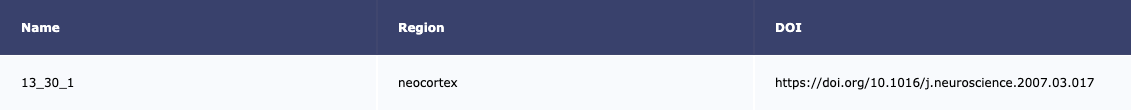

In [41]:
primary_brain_region = 'neocortex'
myquery = f'''
SELECT n.neuron_id,
    n.neuron_name AS Name, 
    n.primary_brain_region AS Region, 
    n.png_url,
    nd.reference_doi AS DOI
FROM neuron n
INNER JOIN neuron_doi nd
    ON n.neuron_id = nd.neuron_id
WHERE primary_brain_region = '{primary_brain_region}' AND png_url IS NOT NULL
'''
data = pd.read_sql_query(myquery, con = engine)
data.rename(columns = {'name': 'Name',
                      'region': 'Region',
                      'doi': 'DOI'}, inplace = True)

sampled_row = data.sample()

sampled_row['DOI'] = 'https://doi.org/' + sampled_row['DOI'].iloc[0]
url = sampled_row['png_url']
ff.create_table(sampled_row[['Name', 'Region', 'DOI']])

In [31]:
sampled_row['DOI'].iloc[0]

'10.1126/science.aac9462'

In [37]:
data

,neuron_id,Name,Region,png_url,DOI
0,1,cnic_001,neocortex,http://neuromorpho.org/images/imageFiles/Wearn...,https://doi.org/https://doi.org/https://doi.or...
1,1,cnic_001,neocortex,http://neuromorpho.org/images/imageFiles/Wearn...,https://doi.org/https://doi.org/https://doi.or...
2,10,cnic_041,neocortex,http://neuromorpho.org/images/imageFiles/Wearn...,https://doi.org/https://doi.org/https://doi.or...
3,10,cnic_041,neocortex,http://neuromorpho.org/images/imageFiles/Wearn...,https://doi.org/https://doi.org/https://doi.or...
4,1000,DS3_030701,neocortex,http://neuromorpho.org/images/imageFiles/Staig...,https://doi.org/https://doi.org/https://doi.or...
...,...,...,...,...,...
55697,99961,Blue12_9-17-12_sec2_Neuron7,neocortex,http://neuromorpho.org/images/imageFiles/Hrvoj...,https://doi.org/https://doi.org/https://doi.or...
55698,99962,Blue9_9-17-12_sec3_Neuron10,neocortex,http://neuromorpho.org/images/imageFiles/Hrvoj...,https://doi.org/https://doi.org/https://doi.or...
55699,99963,Blue9_9-17-12_sec3_Neuron9,neocortex,http://neuromorpho.org/images/imageFiles/Hrvoj...,https://doi.org/https://doi.org/https://doi.or...
55700,99964,Orange5_3-22-13_sec1_Neuron1,neocortex,http://neuromorpho.org/images/imageFiles/Hrvoj...,https://doi.org/https://doi.org/https://doi.or...


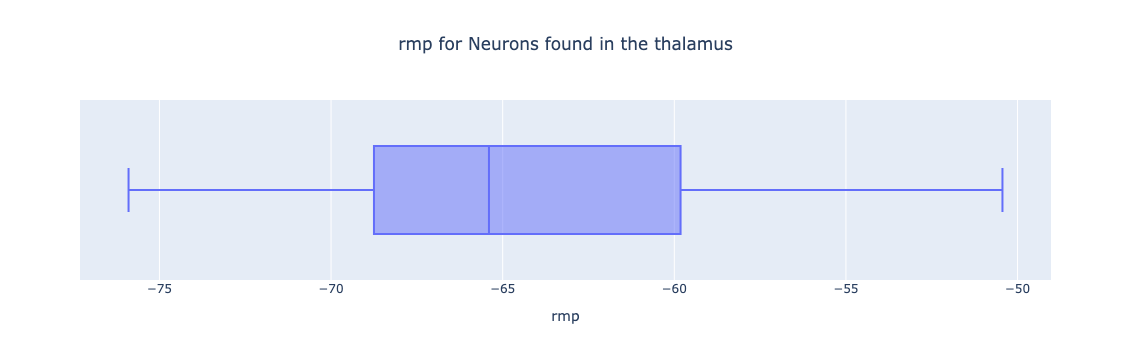

In [80]:
value = 'rmp'
primary_brain_region = 'thalamus'
myquery = f'''
SELECT {value}
FROM electro
WHERE brainregion = '{primary_brain_region}' AND {value} IS NOT NULL
'''
data = pd.read_sql_query(myquery, con = engine)
xaxis = value
fig = px.box(x = data[value], title = value + ' for Neurons found in the ' + primary_brain_region)
fig.update_layout(xaxis_title = xaxis,
                 title_x = 0.5)

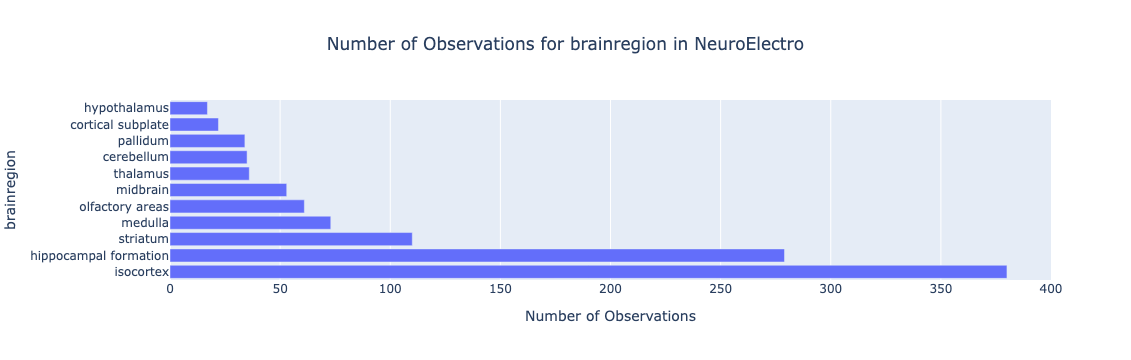

In [101]:
value = 'brainregion'
myquery = f'''
SELECT {value},
    COUNT({value}) AS num_observations
FROM electro
GROUP BY {value}
HAVING {value} IS NOT NULL
ORDER BY num_observations
DESC
'''
data = pd.read_sql_query(myquery, con = engine)
fig = px.bar(y = data[value], x = data['num_observations'], title = 'Number of Observations for ' + value + ' in NeuroElectro')
fig.update_layout(xaxis_title = 'Number of Observations',
                 yaxis_title = value,
                 title_x = 0.5)